# Data Science Lunch and Learn: Bayesian Models
## Thomas Kealy
## 2019/10/14

This talk

- Worked example of a regression model for Radon gas.

Contents
- What is a Bayesian Heirarchical Model.
- Fully pooled model.
- Fully unpooled model.
- Partially pooled model.
- Mixed model.

Radon gas is known to be the highest cause of lung cancer in non-smokers.  It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil. Radon levels vary from household to household.

The EPA did a study of radon levels in 80,000 houses. Two important predictors:

- measurement in basement or first floor (radon higher in basements).
- county uranium level (positive correlation with radon levels).

We will focus on Radon levels in Minnessota.

![title](how-radon-enters-a-house.jpg)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pymc3 import __version__
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(__version__))

Running on PyMC3 v3.7


In [2]:
def load_data():
    from pymc3 import get_data

    # Import radon data
    srrs2 = pd.read_csv(get_data('srrs2.dat'))
    srrs2.columns = srrs2.columns.map(str.strip)
    srrs_mn = srrs2[srrs2.state=='MN'].copy()

    srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
    cty = pd.read_csv(get_data('cty.dat'))
    cty_mn = cty[cty.st=='MN'].copy()
    cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

    srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
    srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
    
    srrs_mn.county = srrs_mn.county.map(str.strip)
    mn_counties = srrs_mn.county.unique()
    counties = len(mn_counties)
    county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

    county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
    srrs_mn['log_radon'] = srrs_mn.activity.apply(np.log1p)
    srrs_mn['u'] = np.log(srrs_mn.Uppm)
    
    srrs_mn.set_index('idnum')

    return srrs_mn, county, county_lookup

In [3]:
srrs_mn, county, county_lookup = load_data()

srrs_mn

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon,u
0,5081,MN,MN,27,55735,5,1,1,3,N,...,1146.499190,1,0,1,AITKIN,27001,0.502054,0,1.163151,-0.689048
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,471.366223,0,0,1,AITKIN,27001,0.502054,0,1.163151,-0.689048
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,433.316718,0,0,1,AITKIN,27001,0.502054,0,1.360977,-0.689048
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,461.623670,0,0,1,AITKIN,27001,0.502054,0,0.693147,-0.689048
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,433.316718,0,0,3,ANOKA,27003,0.428565,1,1.410987,-0.847313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,5995,MN,MN,27,55363,5,1,0,4,Y,...,1146.499190,0,0,171,WRIGHT,27171,0.913909,83,2.001480,-0.090024
923,5996,MN,MN,27,55376,5,1,0,7,Y,...,1105.956867,0,0,171,WRIGHT,27171,0.913909,83,1.704748,-0.090024
924,5997,MN,MN,27,55376,5,1,0,4,Y,...,1214.922779,0,0,171,WRIGHT,27171,0.913909,83,1.791759,-0.090024
925,5998,MN,MN,27,56297,5,1,0,4,Y,...,1177.377355,0,0,173,YELLOW MEDICINE,27173,1.426590,84,1.547563,0.355287


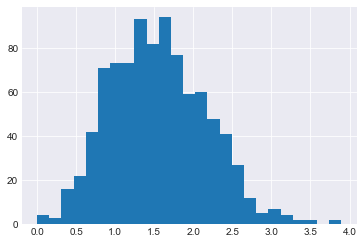

In [4]:
srrs_mn.log_radon.hist(bins=25)

Linear regression:

$$ y = \alpha + \beta X + \varepsilon $$

- $y$ is the output we want to predict (or dependent variable).
- $X$ is our predictor (or independent variable).
- $\alpha$ and $\beta$ are the coefficients of the model.
- $\varepsilon$ is error term (assumed to be normally distributed).

Probabilistic reformulation:

$$ y \sim \mathcal{N}\left( \alpha + \beta X, \sigma^2 \right) $$ 

- we view $y$ as a random variable of which each element  is distributed according to a Normal distribution. 
- The mean of this normal distribution is provided by our linear predictor with variance $\sigma^2$.

While this is essentially the same model, there are two critical advantages of Bayesian estimation:

- Priors: We can quantify any prior knowledge we might have by placing priors on the paramters. 

For example, if we think that σ is likely to be small we would choose a prior with more probability mass on low values.

- Quantifying uncertainty: We do not get a single estimate of $\beta$ as above but instead a complete posterior distribution about how likely different values of $\beta$ are. 

For example, with few data points our uncertainty in $\beta$ will be very high and we'd be getting very wide posteriors.

The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

### Pooled model

Treat all counties the same, estimate a single Radon level

$$ y_{i} = \alpha + \beta X_{i} + \varepsilon_i $$ 

- estimating one intercept and slope for all counties.
- i.e $X_i$ is a binary indicator of a basement present



When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance):
![title](pooled.png)

In [5]:
import pymc3 as pm


class ObserverModel(pm.Model):
    """Stores observed variables until the model is created."""
    def __init__(self, observed):
        self.observed = observed
        super(ObserverModel, self).__init__()

    def Var(self, name, dist, data=None, total_size=None):
        return super(ObserverModel, self).Var(name, dist, data=self.observed.get(name, data), total_size=total_size)


def sampled(f):
    """Decorator to delay initializing pymc3 model until data is passed in."""
    def wrapped_f(**observed):
        try:
            with ObserverModel(observed) as model:
                f(**observed)
        except TypeError:
            with ObserverModel(observed) as model:
                f()
        return model
    return wrapped_f

In [6]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz

floor = srrs_mn.floor.values
log_radon = srrs_mn.log_radon.values

@sampled
def pooled_model(X, y):
    beta = Normal('beta', 0, sd=1.0, shape=2)
    sigma = HalfCauchy('sigma', 5)
    theta = beta[0] + beta[1]*floor
    y = Normal('y', theta, sd=sigma, observed=log_radon)

In [7]:
with pooled_model(X=floor, y=log_radon):
    pooled_trace = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1698.17draws/s]


### Unpooled model

Model radon in each county independently.


$$ y_{i} = \alpha_{j[i]} + \beta X_{i} + \varepsilon_i $$ 

- estimating $n$ different intercepts and slopes

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are to large to combine them:
![title](unpooled.png)

In [8]:
from statsmodels.formula.api import ols
unpooled_fit = ols('log_radon ~ C(county) + floor - 1', srrs_mn).fit()
unpooled_estimates = unpooled_fit.params

b0, m0 = pooled_trace['beta'].mean(axis=0)

In [9]:
unpooled_estimates = unpooled_estimates.rename(dict(zip(unpooled_estimates.index.values,[x[10:-1] or x for x in unpooled_estimates.index.values])))
unpooled_se = unpooled_fit.HC3_se.rename(dict(zip(unpooled_fit.HC3_se.index.values, [x[10:-1] or x for x in unpooled_fit.HC3_se.index.values])))

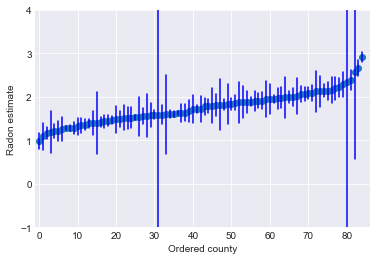

In [10]:
order = unpooled_estimates.sort_values()[1:].index

plt.scatter(range(len(unpooled_estimates)-1), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)-1), unpooled_estimates[order], unpooled_se[order]): 
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Radon estimate');plt.xlabel('Ordered county');

In [13]:
#takes >45 mins!
indiv_traces = {}
for county_name in srrs_mn.county.unique():
    # Select subset of data belonging to county
    c_data = srrs_mn.ix[data.county == county_name]
    c_data = c_data.reset_index(drop=True)
    
    c_log_radon = c_data.log_radon
    c_floor_measure = c_data.floor.values
    
    with pm.Model() as individual_model:
        # Intercept prior
        a = pm.Normal('alpha', mu=0, sd=1)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=1)
    
        # Model error prior
        eps = pm.HalfCauchy('eps', beta=1)
    
        # Linear model
        radon_est = a + b * c_floor_measure
    
        # Data likelihood
        y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=c_log_radon)

        # Inference button (TM)!
        trace = pm.sample(progressbar=False)
        
    indiv_traces[county_name] = trace

/Users/thomas.kealy/anaconda3/envs/bayeslal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
The number of effective samples is smaller than 25% for some parameters.
/Users/thomas.kealy/anaconda3/envs/bayeslal/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing N

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
The acceptance probability does not match the target. It is 0.889021484512857, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampli

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
The acceptance probability does not match the target. It is 0.8834982517123763, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]
There were 6 divergences after tuning. Increase `target_acce

In [ ]:
sample_counties = ('LAC QUI PARLE', 
                   'AITKIN', 
                   'KOOCHICHING', 
                   'DOUGLAS', 
                   'CLAY', 
                   'STEARNS', 
                   'RAMSEY', 
                   'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    m,b = unpooled_estimates[['floor', c]]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

Neither of these models are satisfactory:
- if we are trying to identify high-radon counties, pooling is useless
- we do not trust extreme unpooled estimates produced by models using few observations

### Heirarchical Models

Hierarchical or multilevel modeling is a generalization of regression modeling. A hierarchical model is a particular multilevel model where parameters are nested within one another.

Observational units are often naturally clustered. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

E.g. There are many houses within counties.

Multilevel models are regression models
- The model parameters are given probability models. 
- This implies that model parameters are allowed to vary by group.

Some multilevel structures are not hierarchical.

e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is parital pooling.
![title](partial_pool.png)

## Varying Intercept

In the language of previous slides:

$$ y_{c} = \beta_{0_c} + \beta_{floor} X_{floor_{c}} + \varepsilon_c $$ 

$$ \beta_{0_c} \sim \mathcal{N}\left( \mu_{\beta_{0_c}}, \sigma_{\beta_{0_c}}^2 \right) $$ 

$$ \varepsilon_i \sim \mathcal{N}\left( 0, \sigma_{y}^2 \right) $$

In [ ]:
with Model() as varying_intercept:

    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sd=sigma_a, shape=counties)
    # Common slope
    b = Normal('b', mu=0., sd=1.)

    # Model error
    sd_y = HalfCauchy('sd_y', 5)

    # Expected value
    y_hat = a[county] + b * floor

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sd_y, observed=log_radon)

In [ ]:
with varying_intercept:
    varying_intercept_trace = sample(1000, tune=1000)

In [ ]:
from pymc3 import forestplot, traceplot, plot_posterior

plt.figure(figsize=(6,14))
forestplot(varying_intercept_trace, varnames=['a']);

In [ ]:
plot_posterior(varying_intercept_trace, varnames=['sigma_a', 'b'])

In [ ]:
xvals = np.arange(2)
bp = varying_intercept_trace[a].mean(axis=0)
mp = varying_intercept_trace[b].mean(axis=0)
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1)

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):

    # Plot county data
    y = srrs_mn[srrs_mn['county']==c]['log_radon']
    x = srrs_mn[srrs_mn['county']==c]['floor']
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model
    m,b = np.nan, unpooled_estimates[c]

    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b)
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(xvals, mp*xvals+bp[county_lookup[c]], 'k:')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')


In [ ]:
with Model() as varying_intercept_slope:

    # Priors
    mu_a = Normal('mu_a', mu=0., sd=1.)
    sigma_a = HalfCauchy('sigma_a', 5)
    mu_b = Normal('mu_b', mu=0., sd=1.)
    sigma_b = HalfCauchy('sigma_b', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sd=sigma_a, shape=counties)
    # Random slopes
    b = Normal('b', mu=mu_b, sd=sigma_b, shape=counties)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a[county] + b[county] * floor

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)


In [ ]:
with varying_intercept_slope:
    varying_intercept_slope_trace = sample(1000, tune=1000)

In [ ]:
plt.figure(figsize=(6,16))
forestplot(varying_intercept_slope_trace, varnames=['a','b']);


In [ ]:
from pymc3 import Deterministic

u = srrs_mn['u']

with Model() as hierarchical_intercept:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County uranium model for slope
    gamma_0 = Normal('gamma_0', mu=0., sd=1.)
    gamma_1 = Normal('gamma_1', mu=0., sd=1.)


    # Uranium model for intercept
    mu_a = gamma_0 + gamma_1*u
    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, sd=sigma_a, shape=counties)
    a = Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sd=1.)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * floor

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

In [ ]:
with hierarchical_intercept:
    hierarchical_intercept_trace = sample(1000, tune=1000)

In [ ]:
a_means = hierarchical_intercept_trace['a'].mean(axis=0)
plt.scatter(u, a_means)
g0 = hierarchical_intercept_trace['gamma_0'].mean()
g1 = hierarchical_intercept_trace['gamma_1'].mean()
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(-1, 0.8)

a_se = hierarchical_intercept_trace['a'].std(axis=0)
for ui, m, se in zip(u, a_means, a_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('County-level uranium'); plt.ylabel('Intercept estimate');

In [ ]:
xbar = srrs_mn.groupby('county')['floor'].mean().rename(county_lookup).values

In [ ]:
with Model() as contextual_effect:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County uranium model for slope
    gamma = Normal('gamma', mu=0., sd=1e5, shape=3)

    # Uranium model for intercept
    mu_a = Deterministic('mu_a', gamma[0] + gamma[1]*u.values + gamma[2]*xbar[county])

    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, sd=sigma_a, shape=counties)
    a = Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sd=1e15)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * floor

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)


In [ ]:
with contextual_effect:
    contextual_effect_trace = sample(1000, tune=1000)

In [ ]:
with Model() as contextual_pred:

    # Priors
    sigma_a = HalfCauchy('sigma_a', 5)

    # County uranium model for slope
    gamma = Normal('gamma', mu=0., sd=1e5, shape=3)

    # Uranium model for intercept
    mu_a = Deterministic('mu_a', gamma[0] + gamma[1]*u.values + gamma[2]*xbar[county])

    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, sd=sigma_a, shape=counties)
    a = Deterministic('a', mu_a + eps_a[county])

    # Common slope
    b = Normal('b', mu=0., sd=1e15)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a + b * floor

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=log_radon)

    # St Louis county prediction
    stl_pred = Normal('stl_pred', mu=a[69] + b, sd=sigma_y)


In [ ]:
with contextual_pred:
    contextual_pred_trace = sample(1000, tune=1000)

In [ ]:
plot_posterior(contextual_pred_trace, varnames=['stl_pred'])

In [ ]:
traceplot(contextual_pred_trace)

In [ ]:
srrs_mn

In [ ]:
ax = sns.scatterplot(x="floor", y="log_radon", hue="county_code", data=srrs_mn)